In [ ]:



class KDNode:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None

def insert(x, t, cd, DIM):
    # Если дерево пустое, создаем новый узел
    if t is None:
        t = KDNode(x)
    # Проверка на дубликаты
    elif x == t.data:
        # Ошибка! Дубликат
        print("Error! Duplicate point.")
        return t
    # Если текущая координата x меньше, рекурсивно вставляем в левое поддерево
    elif x[cd] < t.data[cd]:
        t.left = insert(x, t.left, (cd + 1) % DIM, DIM)
    # Иначе вставляем в правое поддерево
    else:
        t.right = insert(x, t.right, (cd + 1) % DIM, DIM)
    
    # Возвращаем текущий узел
    return t

def plot_kdtree(node, ax, x_min, x_max, y_min, y_max, depth=0):
    if node is None:
        return

    # Нарисовать точку
    ax.plot(node.data[0], node.data[1], 'bo')  # синий кружок для точки
    if depth % 2 == 0:  # вертикальная линия по оси X (если глубина четная)
        ax.plot([node.data[0], node.data[0]], [y_min, y_max], 'r--')  # красная линия
        plot_kdtree(node.left, ax, x_min, node.data[0], y_min, y_max, depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, node.data[0], x_max, y_min, y_max, depth + 1)  # правая ветвь
    else:  # горизонтальная линия по оси Y (если глубина нечетная)
        ax.plot([x_min, x_max], [node.data[1], node.data[1]], 'g--')  # зеленая линия
        plot_kdtree(node.left, ax, x_min, x_max, y_min, node.data[1], depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, x_min, x_max, node.data[1], y_max, depth + 1)  # правая ветвь


def find_min(node, d, cd, DIM):
    # Если узел пустой, возвращаем None
    if node is None:
        return None

    # Если текущая размерность совпадает с искомой
    if cd == d:
        # Если левое поддерево существует, ищем минимальную точку в нем
        if node.left is None:
            return node.data
        # Рекурсивно ищем минимум в левом поддереве
        return find_min(node.left, d, (cd + 1) % DIM, DIM)

    else:
        # Продолжаем искать в поддеревьях
        left_min = find_min(node.left, d, (cd + 1) % DIM, DIM)
        right_min = find_min(node.right, d, (cd + 1) % DIM, DIM)

        # Сравниваем текущую точку с минимальными точками из левого и правого поддеревьев
        # Если поддерево пустое (None), то мы его пропускаем
        min_point = node.data
        if left_min is not None and (left_min[d] < min_point[d]):
            min_point = left_min
        if right_min is not None and (right_min[d] < min_point[d]):
            min_point = right_min
        return min_point
    
def point_delete(point, node, cd, DIM):
    if node is None:
        return None

    next_cd = (cd + 1) % DIM
    
    # Если точка найдена
    if node.data == point:
        # Если есть правое поддерево
        if node.right is not None:
            # Найти минимальную точку в правом поддереве
            min_point = find_min(node.right, cd, next_cd, DIM)
            node.data = min_point
            node.right = point_delete(min_point, node.right, next_cd, DIM)
        
        # Если нет правого поддерева, но есть левое
        elif node.left is not None:
            # Найти минимальную точку в левом поддереве
            min_point = find_min(node.left, cd, next_cd, DIM)
            node.data = min_point
            node.left = point_delete(min_point, node.left, next_cd, DIM)
            node.right = node.left  # Переносим левое поддерево в правое
            node.left = None
        
        # Узел является листом
        else:
            return None  # Удаляем узел полностью
    
    # Рекурсивный поиск точки
    else:
        if point[cd] < node.data[cd]:
            node.left = point_delete(point, node.left, next_cd, DIM)
        else:
            node.right = point_delete(point, node.right, next_cd, DIM)
    
    return node



In [32]:
import math
class BoundingBox:
    def __init__(self, bounds):
        """
        bounds: список [min, max] для каждой размерности
        Пример для 2D: [[x_min, x_max], [y_min, y_max]]
        """
        self.bounds = bounds
    
    def trim_left(self, cd, value):
        """Обрезает BB слева по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][1] = min(new_bounds[cd][1], value)  # уменьшаем max
        return BoundingBox(new_bounds)
    
    def trim_right(self, cd, value):
        """Обрезает BB справа по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][0] = max(new_bounds[cd][0], value)  # увеличиваем min
        return BoundingBox(new_bounds)
    
    def distance_to_point(self, Q):
        """Вычисляет минимальное расстояние от точки Q до BB"""
        dist_sq = 0
        for i in range(len(Q)):
            if Q[i] < self.bounds[i][0]:
                dist_sq += (self.bounds[i][0] - Q[i]) ** 2
            elif Q[i] > self.bounds[i][1]:
                dist_sq += (Q[i] - self.bounds[i][1]) ** 2
            # иначе Q внутри по этой размерности → расстояние = 0
        return math.sqrt(dist_sq)
    

def distance(p1, p2):
    """Вычисляет евклидово расстояние между двумя точками"""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def NN(point, node, cd, rect, DIM):
    global best_point, best_dist
    
    next_cd = (cd + 1) % DIM
    
    if node is None or rect.distance_to_point(point) > best_dist:
        return
    dist = distance(point, node.data)
    if dist < best_dist:
        best_point = node.data
        best_dist = dist
    if point[cd] < node.data[cd]:
        NN(point, node.left, next_cd, rect.trim_left(cd, node.data[cd]), DIM)
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            right_rect = rect.trim_right(cd, node.data[cd])
            NN(point, node.right, next_cd, right_rect, DIM)
        
    else:
        NN(point, node.right, next_cd, rect.trim_right(cd, node.data[cd]), DIM)    
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            left_rect = rect.trim_left(cd, node.data[cd])
            NN(point, node.left, next_cd, left_rect, DIM)


best_point = None
best_dist = float('inf')

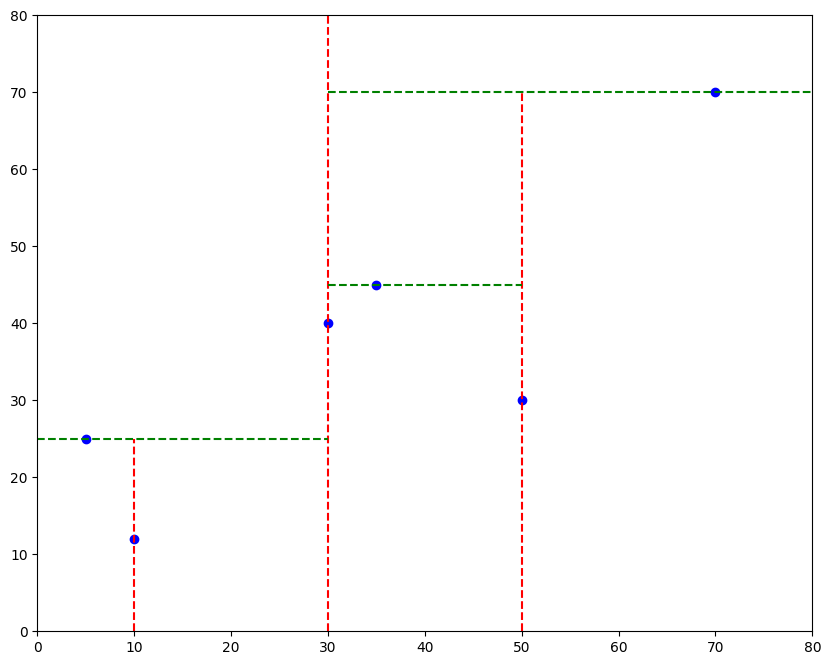

In [33]:
# Список точек для вставки
points = [(30, 40), (5, 25), (10, 12), (70, 70), (50, 30), (35, 45)]

# Создаем корень дерева (начинаем с пустого дерева)
root = None

# Вставляем точки по очереди
DIM = 2  # Размерность (2D)
for point in points:
    root = insert(point, root, 0, DIM)  # начинаем с размерности 0 (сравниваем по оси X)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)

# Визуализируем KD-дерево
plot_kdtree(root, ax, 0, 80, 0, 80)

# Покажем график
plt.show()


In [ ]:



class KDNode:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None

def insert(x, t, cd, DIM):
    # Если дерево пустое, создаем новый узел
    if t is None:
        t = KDNode(x)
    # Проверка на дубликаты
    elif x == t.data:
        # Ошибка! Дубликат
        print("Error! Duplicate point.")
        return t
    # Если текущая координата x меньше, рекурсивно вставляем в левое поддерево
    elif x[cd] < t.data[cd]:
        t.left = insert(x, t.left, (cd + 1) % DIM, DIM)
    # Иначе вставляем в правое поддерево
    else:
        t.right = insert(x, t.right, (cd + 1) % DIM, DIM)
    
    # Возвращаем текущий узел
    return t

def plot_kdtree(node, ax, x_min, x_max, y_min, y_max, depth=0):
    if node is None:
        return

    # Нарисовать точку
    ax.plot(node.data[0], node.data[1], 'bo')  # синий кружок для точки
    if depth % 2 == 0:  # вертикальная линия по оси X (если глубина четная)
        ax.plot([node.data[0], node.data[0]], [y_min, y_max], 'r--')  # красная линия
        plot_kdtree(node.left, ax, x_min, node.data[0], y_min, y_max, depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, node.data[0], x_max, y_min, y_max, depth + 1)  # правая ветвь
    else:  # горизонтальная линия по оси Y (если глубина нечетная)
        ax.plot([x_min, x_max], [node.data[1], node.data[1]], 'g--')  # зеленая линия
        plot_kdtree(node.left, ax, x_min, x_max, y_min, node.data[1], depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, x_min, x_max, node.data[1], y_max, depth + 1)  # правая ветвь


def find_min(node, d, cd, DIM):
    # Если узел пустой, возвращаем None
    if node is None:
        return None

    # Если текущая размерность совпадает с искомой
    if cd == d:
        # Если левое поддерево существует, ищем минимальную точку в нем
        if node.left is None:
            return node.data
        # Рекурсивно ищем минимум в левом поддереве
        return find_min(node.left, d, (cd + 1) % DIM, DIM)

    else:
        # Продолжаем искать в поддеревьях
        left_min = find_min(node.left, d, (cd + 1) % DIM, DIM)
        right_min = find_min(node.right, d, (cd + 1) % DIM, DIM)

        # Сравниваем текущую точку с минимальными точками из левого и правого поддеревьев
        # Если поддерево пустое (None), то мы его пропускаем
        min_point = node.data
        if left_min is not None and (left_min[d] < min_point[d]):
            min_point = left_min
        if right_min is not None and (right_min[d] < min_point[d]):
            min_point = right_min
        return min_point
    
def point_delete(point, node, cd, DIM):
    if node is None:
        return None

    next_cd = (cd + 1) % DIM
    
    # Если точка найдена
    if node.data == point:
        # Если есть правое поддерево
        if node.right is not None:
            # Найти минимальную точку в правом поддереве
            min_point = find_min(node.right, cd, next_cd, DIM)
            node.data = min_point
            node.right = point_delete(min_point, node.right, next_cd, DIM)
        
        # Если нет правого поддерева, но есть левое
        elif node.left is not None:
            # Найти минимальную точку в левом поддереве
            min_point = find_min(node.left, cd, next_cd, DIM)
            node.data = min_point
            node.left = point_delete(min_point, node.left, next_cd, DIM)
            node.right = node.left  # Переносим левое поддерево в правое
            node.left = None
        
        # Узел является листом
        else:
            return None  # Удаляем узел полностью
    
    # Рекурсивный поиск точки
    else:
        if point[cd] < node.data[cd]:
            node.left = point_delete(point, node.left, next_cd, DIM)
        else:
            node.right = point_delete(point, node.right, next_cd, DIM)
    
    return node



In [ ]:
import math
class BoundingBox:
    def __init__(self, bounds):
        """
        bounds: список [min, max] для каждой размерности
        Пример для 2D: [[x_min, x_max], [y_min, y_max]]
        """
        self.bounds = bounds
    
    def trim_left(self, cd, value):
        """Обрезает BB слева по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][1] = min(new_bounds[cd][1], value)  # уменьшаем max
        return BoundingBox(new_bounds)
    
    def trim_right(self, cd, value):
        """Обрезает BB справа по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][0] = max(new_bounds[cd][0], value)  # увеличиваем min
        return BoundingBox(new_bounds)
    
    def distance_to_point(self, Q):
        """Вычисляет минимальное расстояние от точки Q до BB"""
        dist_sq = 0
        for i in range(len(Q)):
            if Q[i] < self.bounds[i][0]:
                dist_sq += (self.bounds[i][0] - Q[i]) ** 2
            elif Q[i] > self.bounds[i][1]:
                dist_sq += (Q[i] - self.bounds[i][1]) ** 2
            # иначе Q внутри по этой размерности → расстояние = 0
        return math.sqrt(dist_sq)
    

def distance(p1, p2):
    """Вычисляет евклидово расстояние между двумя точками"""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def NN(point, node, cd, rect, DIM):
    global best_point, best_dist
    
    next_cd = (cd + 1) % DIM
    
    if node is None or rect.distance_to_point(point) > best_dist:
        return
    dist = distance(point, node.data)
    if dist < best_dist:
        best_point = node.data
        best_dist = dist
    if point[cd] < node.data[cd]:
        NN(point, node.left, next_cd, rect.trim_left(cd, node.data[cd]), DIM)
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            right_rect = rect.trim_right(cd, node.data[cd])
            NN(point, node.right, next_cd, right_rect, DIM)
        
    else:
        NN(point, node.right, next_cd, rect.trim_right(cd, node.data[cd]), DIM)    
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            left_rect = rect.trim_left(cd, node.data[cd])
            NN(point, node.left, next_cd, left_rect, DIM)


best_point = None
best_dist = float('inf')

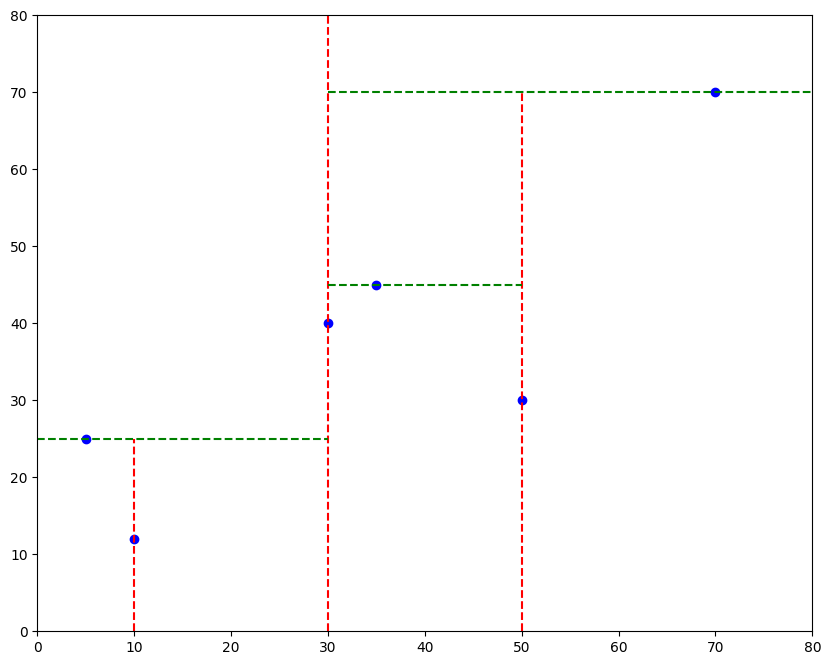

In [ ]:
# Список точек для вставки
points = [(30, 40), (5, 25), (10, 12), (70, 70), (50, 30), (35, 45)]

# Создаем корень дерева (начинаем с пустого дерева)
root = None

# Вставляем точки по очереди
DIM = 2  # Размерность (2D)
for point in points:
    root = insert(point, root, 0, DIM)  # начинаем с размерности 0 (сравниваем по оси X)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)

# Визуализируем KD-дерево
plot_kdtree(root, ax, 0, 80, 0, 80)

# Покажем график
plt.show()


In [ ]:
min_point_x = find_min(root, 0, 0, DIM)
min_point_y = find_min(root, 1, 0, DIM)
print(f"Minimum point along x-axis: {min_point_x}")
print(f"Minimum point along y-axis: {min_point_y}")


Minimum point along x-axis: (5, 25)
Minimum point along y-axis: (10, 12)


In [ ]:
Q = [3, 20]
bounding_box = BoundingBox([[float('-inf'), float('inf')] for _ in range(DIM)])
NN(Q, root, 0, bounding_box, DIM)
print(f"Nearest neighbor to {Q}: {best_point} with distance {best_dist}")

Nearest neighbor to [3, 20]: (5, 25) with distance 5.385164807134504


In [ ]:



class KDNode:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None

def insert(x, t, cd, DIM):
    # Если дерево пустое, создаем новый узел
    if t is None:
        t = KDNode(x)
    # Проверка на дубликаты
    elif x == t.data:
        # Ошибка! Дубликат
        print("Error! Duplicate point.")
        return t
    # Если текущая координата x меньше, рекурсивно вставляем в левое поддерево
    elif x[cd] < t.data[cd]:
        t.left = insert(x, t.left, (cd + 1) % DIM, DIM)
    # Иначе вставляем в правое поддерево
    else:
        t.right = insert(x, t.right, (cd + 1) % DIM, DIM)
    
    # Возвращаем текущий узел
    return t

def plot_kdtree(node, ax, x_min, x_max, y_min, y_max, depth=0):
    if node is None:
        return

    # Нарисовать точку
    ax.plot(node.data[0], node.data[1], 'bo')  # синий кружок для точки
    if depth % 2 == 0:  # вертикальная линия по оси X (если глубина четная)
        ax.plot([node.data[0], node.data[0]], [y_min, y_max], 'r--')  # красная линия
        plot_kdtree(node.left, ax, x_min, node.data[0], y_min, y_max, depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, node.data[0], x_max, y_min, y_max, depth + 1)  # правая ветвь
    else:  # горизонтальная линия по оси Y (если глубина нечетная)
        ax.plot([x_min, x_max], [node.data[1], node.data[1]], 'g--')  # зеленая линия
        plot_kdtree(node.left, ax, x_min, x_max, y_min, node.data[1], depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, x_min, x_max, node.data[1], y_max, depth + 1)  # правая ветвь


def find_min(node, d, cd, DIM):
    # Если узел пустой, возвращаем None
    if node is None:
        return None

    # Если текущая размерность совпадает с искомой
    if cd == d:
        # Если левое поддерево существует, ищем минимальную точку в нем
        if node.left is None:
            return node.data
        # Рекурсивно ищем минимум в левом поддереве
        return find_min(node.left, d, (cd + 1) % DIM, DIM)

    else:
        # Продолжаем искать в поддеревьях
        left_min = find_min(node.left, d, (cd + 1) % DIM, DIM)
        right_min = find_min(node.right, d, (cd + 1) % DIM, DIM)

        # Сравниваем текущую точку с минимальными точками из левого и правого поддеревьев
        # Если поддерево пустое (None), то мы его пропускаем
        min_point = node.data
        if left_min is not None and (left_min[d] < min_point[d]):
            min_point = left_min
        if right_min is not None and (right_min[d] < min_point[d]):
            min_point = right_min
        return min_point
    
def point_delete(point, node, cd, DIM):
    if node is None:
        return None

    next_cd = (cd + 1) % DIM
    
    # Если точка найдена
    if node.data == point:
        # Если есть правое поддерево
        if node.right is not None:
            # Найти минимальную точку в правом поддереве
            min_point = find_min(node.right, cd, next_cd, DIM)
            node.data = min_point
            node.right = point_delete(min_point, node.right, next_cd, DIM)
        
        # Если нет правого поддерева, но есть левое
        elif node.left is not None:
            # Найти минимальную точку в левом поддереве
            min_point = find_min(node.left, cd, next_cd, DIM)
            node.data = min_point
            node.left = point_delete(min_point, node.left, next_cd, DIM)
            node.right = node.left  # Переносим левое поддерево в правое
            node.left = None
        
        # Узел является листом
        else:
            return None  # Удаляем узел полностью
    
    # Рекурсивный поиск точки
    else:
        if point[cd] < node.data[cd]:
            node.left = point_delete(point, node.left, next_cd, DIM)
        else:
            node.right = point_delete(point, node.right, next_cd, DIM)
    
    return node



In [ ]:
import math
class BoundingBox:
    def __init__(self, bounds):
        """
        bounds: список [min, max] для каждой размерности
        Пример для 2D: [[x_min, x_max], [y_min, y_max]]
        """
        self.bounds = bounds
    
    def trim_left(self, cd, value):
        """Обрезает BB слева по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][1] = min(new_bounds[cd][1], value)  # уменьшаем max
        return BoundingBox(new_bounds)
    
    def trim_right(self, cd, value):
        """Обрезает BB справа по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][0] = max(new_bounds[cd][0], value)  # увеличиваем min
        return BoundingBox(new_bounds)
    
    def distance_to_point(self, Q):
        """Вычисляет минимальное расстояние от точки Q до BB"""
        dist_sq = 0
        for i in range(len(Q)):
            if Q[i] < self.bounds[i][0]:
                dist_sq += (self.bounds[i][0] - Q[i]) ** 2
            elif Q[i] > self.bounds[i][1]:
                dist_sq += (Q[i] - self.bounds[i][1]) ** 2
            # иначе Q внутри по этой размерности → расстояние = 0
        return math.sqrt(dist_sq)
    

def distance(p1, p2):
    """Вычисляет евклидово расстояние между двумя точками"""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def NN(point, node, cd, rect, DIM):
    global best_point, best_dist
    
    next_cd = (cd + 1) % DIM
    
    if node is None or rect.distance_to_point(point) > best_dist:
        return
    dist = distance(point, node.data)
    if dist < best_dist:
        best_point = node.data
        best_dist = dist
    if point[cd] < node.data[cd]:
        NN(point, node.left, next_cd, rect.trim_left(cd, node.data[cd]), DIM)
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            right_rect = rect.trim_right(cd, node.data[cd])
            NN(point, node.right, next_cd, right_rect, DIM)
        
    else:
        NN(point, node.right, next_cd, rect.trim_right(cd, node.data[cd]), DIM)    
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            left_rect = rect.trim_left(cd, node.data[cd])
            NN(point, node.left, next_cd, left_rect, DIM)


best_point = None
best_dist = float('inf')

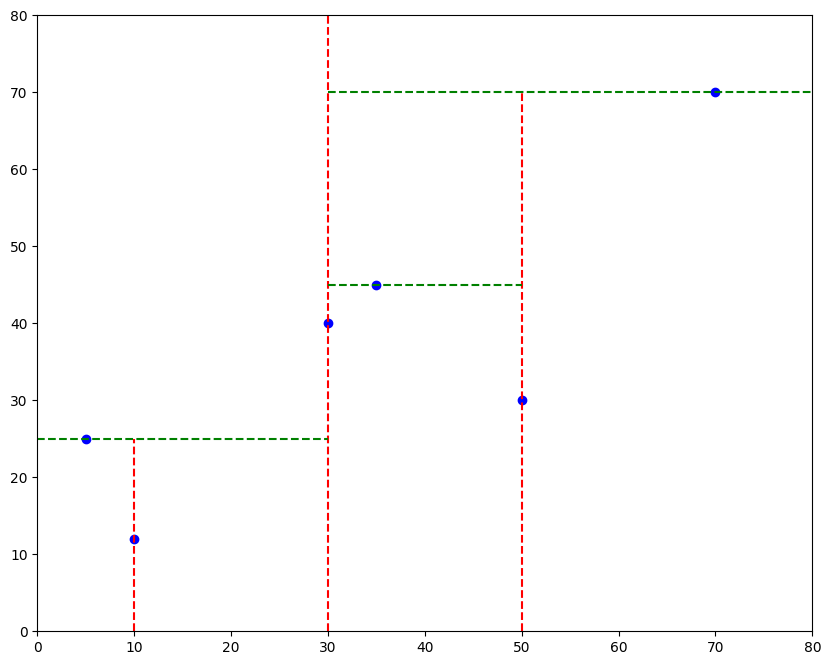

In [ ]:
# Список точек для вставки
points = [(30, 40), (5, 25), (10, 12), (70, 70), (50, 30), (35, 45)]

# Создаем корень дерева (начинаем с пустого дерева)
root = None

# Вставляем точки по очереди
DIM = 2  # Размерность (2D)
for point in points:
    root = insert(point, root, 0, DIM)  # начинаем с размерности 0 (сравниваем по оси X)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)

# Визуализируем KD-дерево
plot_kdtree(root, ax, 0, 80, 0, 80)

# Покажем график
plt.show()


In [ ]:
min_point_x = find_min(root, 0, 0, DIM)
min_point_y = find_min(root, 1, 0, DIM)
print(f"Minimum point along x-axis: {min_point_x}")
print(f"Minimum point along y-axis: {min_point_y}")


Minimum point along x-axis: (5, 25)
Minimum point along y-axis: (10, 12)


In [ ]:
Q = [3, 20]
bounding_box = BoundingBox([[float('-inf'), float('inf')] for _ in range(DIM)])
NN(Q, root, 0, bounding_box, DIM)
print(f"Nearest neighbor to {Q}: {best_point} with distance {best_dist}")

Nearest neighbor to [3, 20]: (5, 25) with distance 5.385164807134504


In [ ]:



class KDNode:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None

def insert(x, t, cd, DIM):
    # Если дерево пустое, создаем новый узел
    if t is None:
        t = KDNode(x)
    # Проверка на дубликаты
    elif x == t.data:
        # Ошибка! Дубликат
        print("Error! Duplicate point.")
        return t
    # Если текущая координата x меньше, рекурсивно вставляем в левое поддерево
    elif x[cd] < t.data[cd]:
        t.left = insert(x, t.left, (cd + 1) % DIM, DIM)
    # Иначе вставляем в правое поддерево
    else:
        t.right = insert(x, t.right, (cd + 1) % DIM, DIM)
    
    # Возвращаем текущий узел
    return t

def plot_kdtree(node, ax, x_min, x_max, y_min, y_max, depth=0):
    if node is None:
        return

    # Нарисовать точку
    ax.plot(node.data[0], node.data[1], 'bo')  # синий кружок для точки
    if depth % 2 == 0:  # вертикальная линия по оси X (если глубина четная)
        ax.plot([node.data[0], node.data[0]], [y_min, y_max], 'r--')  # красная линия
        plot_kdtree(node.left, ax, x_min, node.data[0], y_min, y_max, depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, node.data[0], x_max, y_min, y_max, depth + 1)  # правая ветвь
    else:  # горизонтальная линия по оси Y (если глубина нечетная)
        ax.plot([x_min, x_max], [node.data[1], node.data[1]], 'g--')  # зеленая линия
        plot_kdtree(node.left, ax, x_min, x_max, y_min, node.data[1], depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, x_min, x_max, node.data[1], y_max, depth + 1)  # правая ветвь


def find_min(node, d, cd, DIM):
    # Если узел пустой, возвращаем None
    if node is None:
        return None

    # Если текущая размерность совпадает с искомой
    if cd == d:
        # Если левое поддерево существует, ищем минимальную точку в нем
        if node.left is None:
            return node.data
        # Рекурсивно ищем минимум в левом поддереве
        return find_min(node.left, d, (cd + 1) % DIM, DIM)

    else:
        # Продолжаем искать в поддеревьях
        left_min = find_min(node.left, d, (cd + 1) % DIM, DIM)
        right_min = find_min(node.right, d, (cd + 1) % DIM, DIM)

        # Сравниваем текущую точку с минимальными точками из левого и правого поддеревьев
        # Если поддерево пустое (None), то мы его пропускаем
        min_point = node.data
        if left_min is not None and (left_min[d] < min_point[d]):
            min_point = left_min
        if right_min is not None and (right_min[d] < min_point[d]):
            min_point = right_min
        return min_point
    
def point_delete(point, node, cd, DIM):
    if node is None:
        return None

    next_cd = (cd + 1) % DIM
    
    # Если точка найдена
    if node.data == point:
        # Если есть правое поддерево
        if node.right is not None:
            # Найти минимальную точку в правом поддереве
            min_point = find_min(node.right, cd, next_cd, DIM)
            node.data = min_point
            node.right = point_delete(min_point, node.right, next_cd, DIM)
        
        # Если нет правого поддерева, но есть левое
        elif node.left is not None:
            # Найти минимальную точку в левом поддереве
            min_point = find_min(node.left, cd, next_cd, DIM)
            node.data = min_point
            node.left = point_delete(min_point, node.left, next_cd, DIM)
            node.right = node.left  # Переносим левое поддерево в правое
            node.left = None
        
        # Узел является листом
        else:
            return None  # Удаляем узел полностью
    
    # Рекурсивный поиск точки
    else:
        if point[cd] < node.data[cd]:
            node.left = point_delete(point, node.left, next_cd, DIM)
        else:
            node.right = point_delete(point, node.right, next_cd, DIM)
    
    return node



In [ ]:
import math
class BoundingBox:
    def __init__(self, bounds):
        """
        bounds: список [min, max] для каждой размерности
        Пример для 2D: [[x_min, x_max], [y_min, y_max]]
        """
        self.bounds = bounds
    
    def trim_left(self, cd, value):
        """Обрезает BB слева по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][1] = min(new_bounds[cd][1], value)  # уменьшаем max
        return BoundingBox(new_bounds)
    
    def trim_right(self, cd, value):
        """Обрезает BB справа по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][0] = max(new_bounds[cd][0], value)  # увеличиваем min
        return BoundingBox(new_bounds)
    
    def distance_to_point(self, Q):
        """Вычисляет минимальное расстояние от точки Q до BB"""
        dist_sq = 0
        for i in range(len(Q)):
            if Q[i] < self.bounds[i][0]:
                dist_sq += (self.bounds[i][0] - Q[i]) ** 2
            elif Q[i] > self.bounds[i][1]:
                dist_sq += (Q[i] - self.bounds[i][1]) ** 2
            # иначе Q внутри по этой размерности → расстояние = 0
        return math.sqrt(dist_sq)
    

def distance(p1, p2):
    """Вычисляет евклидово расстояние между двумя точками"""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def NN(point, node, cd, rect, DIM):
    global best_point, best_dist
    
    next_cd = (cd + 1) % DIM
    
    if node is None or rect.distance_to_point(point) > best_dist:
        return
    dist = distance(point, node.data)
    if dist < best_dist:
        best_point = node.data
        best_dist = dist
    if point[cd] < node.data[cd]:
        NN(point, node.left, next_cd, rect.trim_left(cd, node.data[cd]), DIM)
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            right_rect = rect.trim_right(cd, node.data[cd])
            NN(point, node.right, next_cd, right_rect, DIM)
        
    else:
        NN(point, node.right, next_cd, rect.trim_right(cd, node.data[cd]), DIM)    
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            left_rect = rect.trim_left(cd, node.data[cd])
            NN(point, node.left, next_cd, left_rect, DIM)


best_point = None
best_dist = float('inf')

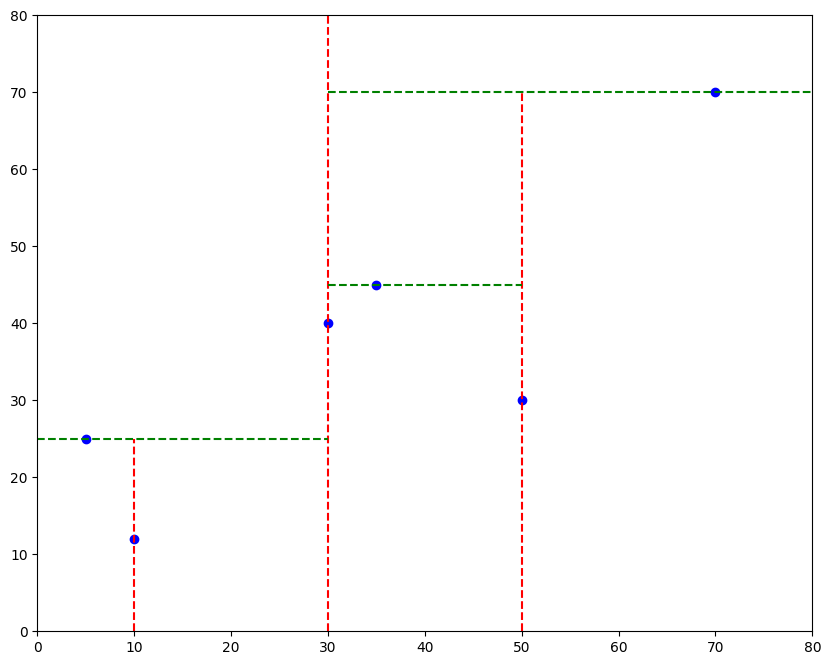

In [ ]:
# Список точек для вставки
points = [(30, 40), (5, 25), (10, 12), (70, 70), (50, 30), (35, 45)]

# Создаем корень дерева (начинаем с пустого дерева)
root = None

# Вставляем точки по очереди
DIM = 2  # Размерность (2D)
for point in points:
    root = insert(point, root, 0, DIM)  # начинаем с размерности 0 (сравниваем по оси X)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)

# Визуализируем KD-дерево
plot_kdtree(root, ax, 0, 80, 0, 80)

# Покажем график
plt.show()


In [ ]:
min_point_x = find_min(root, 0, 0, DIM)
min_point_y = find_min(root, 1, 0, DIM)
print(f"Minimum point along x-axis: {min_point_x}")
print(f"Minimum point along y-axis: {min_point_y}")


Minimum point along x-axis: (5, 25)
Minimum point along y-axis: (10, 12)


In [ ]:
Q = [3, 20]
bounding_box = BoundingBox([[float('-inf'), float('inf')] for _ in range(DIM)])
NN(Q, root, 0, bounding_box, DIM)
print(f"Nearest neighbor to {Q}: {best_point} with distance {best_dist}")

Nearest neighbor to [3, 20]: (5, 25) with distance 5.385164807134504


In [ ]:



class KDNode:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None

def insert(x, t, cd, DIM):
    # Если дерево пустое, создаем новый узел
    if t is None:
        t = KDNode(x)
    # Проверка на дубликаты
    elif x == t.data:
        # Ошибка! Дубликат
        print("Error! Duplicate point.")
        return t
    # Если текущая координата x меньше, рекурсивно вставляем в левое поддерево
    elif x[cd] < t.data[cd]:
        t.left = insert(x, t.left, (cd + 1) % DIM, DIM)
    # Иначе вставляем в правое поддерево
    else:
        t.right = insert(x, t.right, (cd + 1) % DIM, DIM)
    
    # Возвращаем текущий узел
    return t

def plot_kdtree(node, ax, x_min, x_max, y_min, y_max, depth=0):
    if node is None:
        return

    # Нарисовать точку
    ax.plot(node.data[0], node.data[1], 'bo')  # синий кружок для точки
    if depth % 2 == 0:  # вертикальная линия по оси X (если глубина четная)
        ax.plot([node.data[0], node.data[0]], [y_min, y_max], 'r--')  # красная линия
        plot_kdtree(node.left, ax, x_min, node.data[0], y_min, y_max, depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, node.data[0], x_max, y_min, y_max, depth + 1)  # правая ветвь
    else:  # горизонтальная линия по оси Y (если глубина нечетная)
        ax.plot([x_min, x_max], [node.data[1], node.data[1]], 'g--')  # зеленая линия
        plot_kdtree(node.left, ax, x_min, x_max, y_min, node.data[1], depth + 1)  # левая ветвь
        plot_kdtree(node.right, ax, x_min, x_max, node.data[1], y_max, depth + 1)  # правая ветвь


def find_min(node, d, cd, DIM):
    # Если узел пустой, возвращаем None
    if node is None:
        return None

    # Если текущая размерность совпадает с искомой
    if cd == d:
        # Если левое поддерево существует, ищем минимальную точку в нем
        if node.left is None:
            return node.data
        # Рекурсивно ищем минимум в левом поддереве
        return find_min(node.left, d, (cd + 1) % DIM, DIM)

    else:
        # Продолжаем искать в поддеревьях
        left_min = find_min(node.left, d, (cd + 1) % DIM, DIM)
        right_min = find_min(node.right, d, (cd + 1) % DIM, DIM)

        # Сравниваем текущую точку с минимальными точками из левого и правого поддеревьев
        # Если поддерево пустое (None), то мы его пропускаем
        min_point = node.data
        if left_min is not None and (left_min[d] < min_point[d]):
            min_point = left_min
        if right_min is not None and (right_min[d] < min_point[d]):
            min_point = right_min
        return min_point
    
def point_delete(point, node, cd, DIM):
    if node is None:
        return None

    next_cd = (cd + 1) % DIM
    
    # Если точка найдена
    if node.data == point:
        # Если есть правое поддерево
        if node.right is not None:
            # Найти минимальную точку в правом поддереве
            min_point = find_min(node.right, cd, next_cd, DIM)
            node.data = min_point
            node.right = point_delete(min_point, node.right, next_cd, DIM)
        
        # Если нет правого поддерева, но есть левое
        elif node.left is not None:
            # Найти минимальную точку в левом поддереве
            min_point = find_min(node.left, cd, next_cd, DIM)
            node.data = min_point
            node.left = point_delete(min_point, node.left, next_cd, DIM)
            node.right = node.left  # Переносим левое поддерево в правое
            node.left = None
        
        # Узел является листом
        else:
            return None  # Удаляем узел полностью
    
    # Рекурсивный поиск точки
    else:
        if point[cd] < node.data[cd]:
            node.left = point_delete(point, node.left, next_cd, DIM)
        else:
            node.right = point_delete(point, node.right, next_cd, DIM)
    
    return node



In [ ]:
import math
class BoundingBox:
    def __init__(self, bounds):
        """
        bounds: список [min, max] для каждой размерности
        Пример для 2D: [[x_min, x_max], [y_min, y_max]]
        """
        self.bounds = bounds
    
    def trim_left(self, cd, value):
        """Обрезает BB слева по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][1] = min(new_bounds[cd][1], value)  # уменьшаем max
        return BoundingBox(new_bounds)
    
    def trim_right(self, cd, value):
        """Обрезает BB справа по размерности cd в точке value"""
        new_bounds = [dim.copy() for dim in self.bounds]
        new_bounds[cd][0] = max(new_bounds[cd][0], value)  # увеличиваем min
        return BoundingBox(new_bounds)
    
    def distance_to_point(self, Q):
        """Вычисляет минимальное расстояние от точки Q до BB"""
        dist_sq = 0
        for i in range(len(Q)):
            if Q[i] < self.bounds[i][0]:
                dist_sq += (self.bounds[i][0] - Q[i]) ** 2
            elif Q[i] > self.bounds[i][1]:
                dist_sq += (Q[i] - self.bounds[i][1]) ** 2
            # иначе Q внутри по этой размерности → расстояние = 0
        return math.sqrt(dist_sq)
    

def distance(p1, p2):
    """Вычисляет евклидово расстояние между двумя точками"""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def NN(point, node, cd, rect, DIM):
    global best_point, best_dist
    
    next_cd = (cd + 1) % DIM
    
    if node is None or rect.distance_to_point(point) > best_dist:
        return
    dist = distance(point, node.data)
    if dist < best_dist:
        best_point = node.data
        best_dist = dist
    if point[cd] < node.data[cd]:
        NN(point, node.left, next_cd, rect.trim_left(cd, node.data[cd]), DIM)
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            right_rect = rect.trim_right(cd, node.data[cd])
            NN(point, node.right, next_cd, right_rect, DIM)
        
    else:
        NN(point, node.right, next_cd, rect.trim_right(cd, node.data[cd]), DIM)    
        plane_dist = abs(point[cd] - node.data[cd])
        if plane_dist < best_dist:
            left_rect = rect.trim_left(cd, node.data[cd])
            NN(point, node.left, next_cd, left_rect, DIM)


best_point = None
best_dist = float('inf')

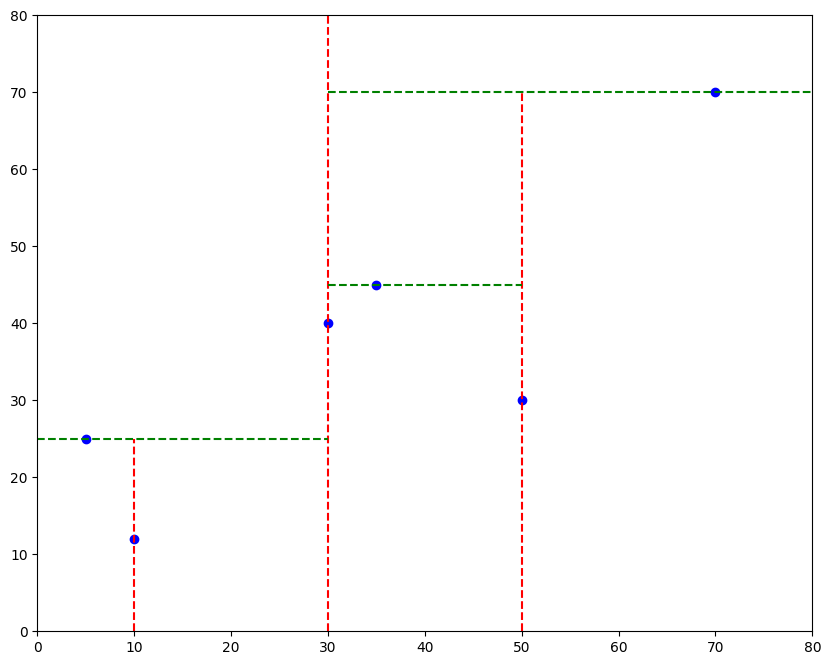

In [ ]:
# Список точек для вставки
points = [(30, 40), (5, 25), (10, 12), (70, 70), (50, 30), (35, 45)]

# Создаем корень дерева (начинаем с пустого дерева)
root = None

# Вставляем точки по очереди
DIM = 2  # Размерность (2D)
for point in points:
    root = insert(point, root, 0, DIM)  # начинаем с размерности 0 (сравниваем по оси X)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)

# Визуализируем KD-дерево
plot_kdtree(root, ax, 0, 80, 0, 80)

# Покажем график
plt.show()


In [ ]:
min_point_x = find_min(root, 0, 0, DIM)
min_point_y = find_min(root, 1, 0, DIM)
print(f"Minimum point along x-axis: {min_point_x}")
print(f"Minimum point along y-axis: {min_point_y}")


Minimum point along x-axis: (5, 25)
Minimum point along y-axis: (10, 12)


In [ ]:
Q = [3, 20]
bounding_box = BoundingBox([[float('-inf'), float('inf')] for _ in range(DIM)])
NN(Q, root, 0, bounding_box, DIM)
print(f"Nearest neighbor to {Q}: {best_point} with distance {best_dist}")

Nearest neighbor to [3, 20]: (5, 25) with distance 5.385164807134504


In [34]:
min_point_x = find_min(root, 0, 0, DIM)
min_point_y = find_min(root, 1, 0, DIM)
print(f"Minimum point along x-axis: {min_point_x}")
print(f"Minimum point along y-axis: {min_point_y}")


Minimum point along x-axis: (5, 25)
Minimum point along y-axis: (10, 12)


In [51]:
Q = [3, 20]
bounding_box = BoundingBox([[float('-inf'), float('inf')] for _ in range(DIM)])
NN(Q, root, 0, bounding_box, DIM)
print(f"Nearest neighbor to {Q}: {best_point} with distance {best_dist}")

Nearest neighbor to [3, 20]: (5, 25) with distance 5.385164807134504
